In [ ]:
# Copyright 2022 - Olman Ureña
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/olmaneuh/olmaneuh-expo/blob/main/playing-with-machine-learning-in-the-cloud/vertex_ai_demo.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run In Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/olmaneuh/olmaneuh-expo/blob/main/playing-with-machine-learning-in-the-cloud/vertex_ai_demo.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View On GitHub
    </a>
  </td>
</table>

# **Vertex AI - Demo**

# **1. Problem Overview**

Classify recycling material given an image.

# **2. Solution: Custom Model On Vertext AI**
[Vertex AI](https://cloud.google.com/vertex-ai) brings together the Google Cloud services for building ML under one, unified UI and API. In Vertex AI, you can now easily train and compare models using AutoML or custom code training and all your models are stored in one central model repository. These models can now be deployed to the same endpoints on Vertex AI.

# **3. Setup And Requirements**
* Sign in to Cloud Console and create a new project _([How to create a Google Cloud project](https://developers.google.com/workspace/guides/create-project))_.
* Enable billing in Cloud Console in order to use Google Cloud resources _([New users of Google Cloud are eligible for the $300USD Free Trial program](https://cloud.google.com/free/docs/free-cloud-features))_.
* Have a deployed endpoint in Vertex AI to get the predictions _(explained and implemented previously in the tech-talk)_.

> **Important:**
>
> Running through this Notebook will cost you around **$22USD** _(taking into account the Machine Learning flow to create the model.)_. Be sure to follow any instructions in the _"Cleaning Up"_ section which advises you how to shut down resources so you don't incur billing.

# **4. Authorize API requests**
As a best practice, Google Cloud recommends the use of service account authorization when calling APIs.

1. [Create a service account for this Notebook](https://cloud.google.com/iam/docs/creating-managing-service-accounts#iam-service-accounts-create-console).
2. [Create a service account key](https://cloud.google.com/iam/docs/creating-managing-service-account-keys#iam-service-account-keys-create-console).

# **5. Setup An Environment Variable**
The environment variable `GOOGLE_APPLICATION_CREDENTIALS` has the default service account private key that will be used. 

The environment variable should be set to the **full path** of the credentials JSON file you saved.


In [1]:
from google.colab import files
import os

# upload files to Colab
uploaded = files.upload()

for file_name in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=file_name, length=len(uploaded[file_name])))
  
  # create an environment variable
  os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = file_name
  print("Service Account Key: {}".format(
      os.environ["GOOGLE_APPLICATION_CREDENTIALS"]))
  

Saving playing-with-ml-in-the-cloud-key.json to playing-with-ml-in-the-cloud-key.json
User uploaded file "playing-with-ml-in-the-cloud-key.json" with length 2361 bytes
Service Account Key: playing-with-ml-in-the-cloud-key.json


# **6. Install Vertex AI SDK For Python**

In [2]:
!pip3 install --upgrade google-cloud-aiplatform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **7. Upload The Images**

Saving cardboard-test.jpg to cardboard-test.jpg
Saving glass-test.jpg to glass-test.jpg
Saving metal-test.jpg to metal-test.jpg
Saving paper-test.jpg to paper-test.jpg
Saving plastic-test.jpg to plastic-test.jpg


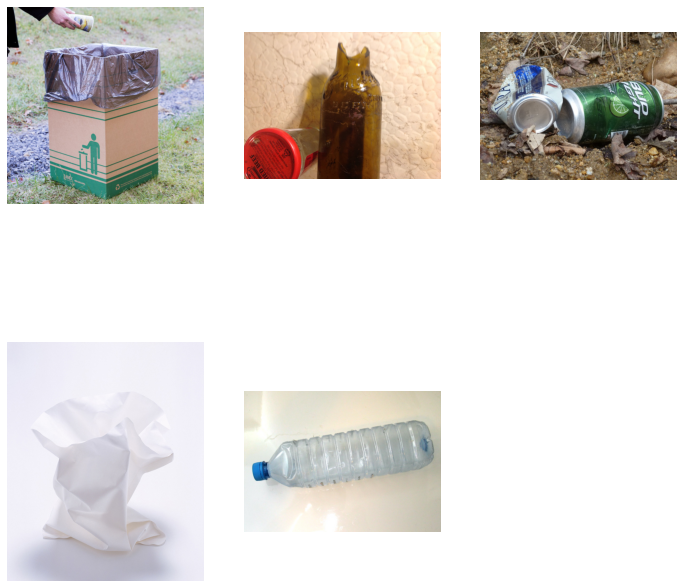

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from google.colab import files

uploaded_imgs = []
uploaded = files.upload()

for file_name in uploaded.keys():
  uploaded_imgs.append(file_name)

# displaying uploaded images
plt.figure(figsize=(12, 12))
for i, img in enumerate(uploaded_imgs):
  img_to_display = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
  ax = plt.subplot(2, 3, i+1)
  plt.imshow(img_to_display)
  plt.axis("off")

# **8. Define Some Methods And Use The Endpoint**

In [7]:
import base64

from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import predict


def get_recycling_class(
    project: str,
    endpoint_id: str,
    filename: str,
    real_label: str,
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client_options = {"api_endpoint": api_endpoint} # The AI Platform services require regional API endpoints.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)

    # read the file content
    # The format of each instance should conform to the deployed model's prediction input schema.
    with open(filename, "rb") as f:
        file_content = f.read()

    encoded_content = base64.b64encode(file_content).decode("utf-8")
    instance = predict.instance.ImageClassificationPredictionInstance(
        content=encoded_content,
    ).to_value()
    instances = [instance]

    # See gs://google-cloud-aiplatform/schema/predict/params/image_classification_1.0.0.yaml for the format of the parameters.
    parameters = predict.params.ImageClassificationPredictionParams(
        confidence_threshold=0.5, max_predictions=1,
    ).to_value()

    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )

    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )

    prediction = dict(response.predictions[0])

    # display the image with the respective labels
    img_to_display = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    plt.imshow(img_to_display)
    plt.title('Inference Label: {}\nConfidence: {:.2f}%\nReal Label: {}'.format(
         prediction['displayNames'][0], 
         100 * prediction['confidences'][0],
         real_label))
    plt.axis("off")

# **9. Execute Some Tests**

In [14]:
# constants
PROJECT = "YOUR_PROJECT_NBR"
ENDPOINT_ID = "YOUR_ENDPOINT_ID"
LOCATION = "REGION"

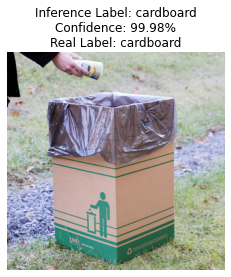

In [9]:
get_recycling_class(
    project=PROJECT,
    endpoint_id=ENDPOINT_ID,
    real_label="cardboard",
    location=LOCATION,
    filename=uploaded_imgs[0]
)

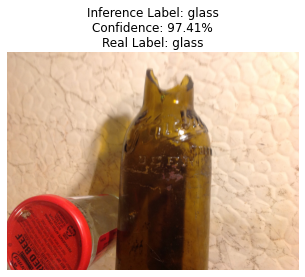

In [10]:
get_recycling_class(
    project=PROJECT,
    endpoint_id=ENDPOINT_ID,
    real_label="glass",
    location=LOCATION,
    filename=uploaded_imgs[1]
)

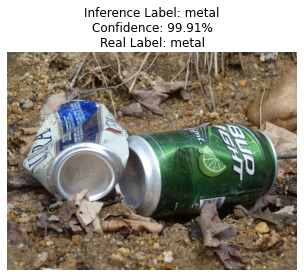

In [11]:
get_recycling_class(
    project=PROJECT,
    endpoint_id=ENDPOINT_ID,
    real_label="metal",
    location=LOCATION,
    filename=uploaded_imgs[2]
)

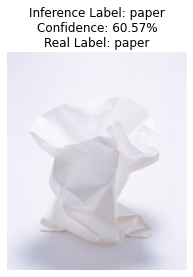

In [12]:
get_recycling_class(
    project=PROJECT,
    endpoint_id=ENDPOINT_ID,
    real_label="paper",
    location=LOCATION,
    filename=uploaded_imgs[3]
)

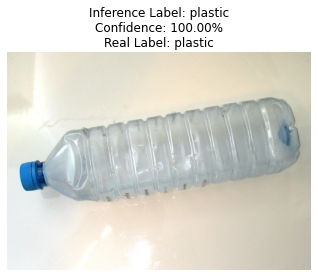

In [13]:
get_recycling_class(
    project=PROJECT,
    endpoint_id=ENDPOINT_ID,
    real_label="plastic",
    location=LOCATION,
    filename=uploaded_imgs[4]
)

# **10. Resources**
*   [Vertex AI SDK for Python Docs](https://googleapis.dev/python/aiplatform/latest/index.html)



# **11. Cleaning Up**
To clean up all resources used in this Notebook, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.